# Plotting the distribution of the tumor cell population and fraction

## Import libraries

In [1]:
# %matplotlib notebook
#  add Python-loader repo to the path 
import sys
sys.path.insert(0, '../Python-loader/')
from pyMCDS import pyMCDS

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import scipy
from fitter_local import Fitter, get_common_distributions, get_distributions
from distfit import distfit
from scipy.integrate import odeint
from adjustText import adjust_text

## Define cell cycle model

In [48]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 6

# output_folder = "output_Live_dt6_NC100_R100/"
# output_folder = "output_Experimental_Settings_R300/output_Ki67_Basic_dt6_NC1000_R300/"
# output_folder = "output_Ki67_Advanced_dt6_NC100_R100/"
# output_folder = "output_Experimental_Settings_R300/output_Flow_Cytometry_dt6_NC1000_R300/"
output_folder = "output_Experimental_Settings_R300/output_Separated_Flow_Cytometry_dt6_NC1000_R300/"

## List output folders

In [49]:
## Type pyMCDS. and hit the tab key to see methods 

sorted(os.listdir("./"+output_folder))

['G0G1_phase_frac_distfit.csv',
 'G0G1_phase_frac_distfit.pdf',
 'G0G1_phase_frac_distfit_weights.csv',
 'G0G1_phase_frac_fit_custom10.csv',
 'G0G1_phase_frac_fit_custom10.pdf',
 'G0G1_phase_frac_fit_custom10_weights.csv',
 'G0G1_phase_frac_hist10.pdf',
 'G0G1_phase_frac_hist20.pdf',
 'G0G1_phase_pop_distfit.csv',
 'G0G1_phase_pop_distfit.pdf',
 'G0G1_phase_pop_distfit_weights.csv',
 'G0G1_phase_pop_fit_custom10.csv',
 'G0G1_phase_pop_fit_custom10.pdf',
 'G0G1_phase_pop_fit_custom10_weights.csv',
 'G0G1_phase_pop_hist10.pdf',
 'G0G1_phase_pop_hist20.pdf',
 'G2_phase_frac_distfit.csv',
 'G2_phase_frac_distfit.pdf',
 'G2_phase_frac_distfit_weights.csv',
 'G2_phase_frac_fit_custom10.csv',
 'G2_phase_frac_fit_custom10.pdf',
 'G2_phase_frac_fit_custom10_weights.csv',
 'G2_phase_frac_hist10.pdf',
 'G2_phase_frac_hist20.pdf',
 'G2_phase_pop_distfit.csv',
 'G2_phase_pop_distfit.pdf',
 'G2_phase_pop_distfit_weights.csv',
 'G2_phase_pop_fit_custom10.csv',
 'G2_phase_pop_fit_custom10.pdf',
 'G2_p

## List *.xml* output files from one replicate

In [50]:
## Type pyMCDS. and hit the tab key to see methods 

file_list = []
for file in os.listdir("./"+output_folder+"output_R00/"):
    if file.endswith(".xml"):
        file_list.append(os.path.join("./"+output_folder+"output_R00/", file))
print(sorted(file_list))

['./output_Experimental_Settings_R300/output_Separated_Flow_Cytometry_dt6_NC1000_R300/output_R00/PhysiCell_settings_Separated_Flow_Cytometry_without_o2_apop_nec.xml', './output_Experimental_Settings_R300/output_Separated_Flow_Cytometry_dt6_NC1000_R300/output_R00/final.xml', './output_Experimental_Settings_R300/output_Separated_Flow_Cytometry_dt6_NC1000_R300/output_R00/initial.xml']


## Compute the number of each tumor cell phenotype over all replicates and simulation times

In [51]:
# num_replicates = 10;
# last_index = 120;

# times = np.zeros( last_index+1 ); 
# if cycle_model == 0:
#     Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_premitotic_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_postmitotic_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 1:
#     Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
#     Ki67_positive_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 2:
#     G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     G2M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 5:
#     live_count = np.zeros( (num_replicates, last_index+1) ); 
# elif cycle_model == 6:
#     G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     G2_phase_count = np.zeros( (num_replicates, last_index+1) ); 
#     M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
# else:
#     print("Unrecognized cell cycle model.")
# apoptotic_count = np.zeros( (num_replicates, last_index+1) ); 
# necrotic_count = np.zeros( (num_replicates, last_index+1) ); 

# for id_replicate in range(num_replicates):
#     folder_name = output_folder+"output_R"+str("%02d"%id_replicate)+'/'
#     for n in range( 0, last_index+1 ):
#         filename = 'output'+"%08i"%n+'.xml'
#         mcds = pyMCDS(filename, folder_name)

#         times[n] = mcds.get_time()
#         cp = mcds.data['discrete_cells']['current_phase']
#         if cycle_model == 0:
#             Ki67_negative = np.argwhere( cp == 3 ).flatten()
#             Ki67_positive_premitotic = np.argwhere( cp == 0 ).flatten()
#             Ki67_positive_postmitotic = np.argwhere( cp == 1 ).flatten()

#             Ki67_negative_count[id_replicate][n] = len( Ki67_negative )
#             Ki67_positive_premitotic_count[id_replicate][n] = len( Ki67_positive_premitotic )
#             Ki67_positive_postmitotic_count[id_replicate][n] = len( Ki67_positive_postmitotic )
#         elif cycle_model == 1:
#             Ki67_negative = np.argwhere( cp == 3 ).flatten()
#             Ki67_positive = np.argwhere( cp == 2 ).flatten()

#             Ki67_negative_count[id_replicate][n] = len( Ki67_negative )
#             Ki67_positive_count[id_replicate][n] = len( Ki67_positive )
#         elif cycle_model == 2:
#             G0G1_phase = np.argwhere( cp == 4 ).flatten()
#             S_phase = np.argwhere( cp == 10 ).flatten()
#             G2M_phase = np.argwhere( cp == 11 ).flatten()

#             G0G1_phase_count[id_replicate][n] = len( G0G1_phase )
#             S_phase_count[id_replicate][n] = len( S_phase )
#             G2M_phase_count[id_replicate][n] = len( G2M_phase )
#         elif cycle_model == 5:
#             live = np.argwhere( cp == 14 ).flatten()

#             live_count[id_replicate][n] = len( live )
#         elif cycle_model == 6:
#             G0G1_phase = np.argwhere( cp == 4 ).flatten()
#             S_phase = np.argwhere( cp == 10 ).flatten()
#             G2_phase = np.argwhere( cp == 12 ).flatten()
#             M_phase = np.argwhere( cp == 13 ).flatten()

#             G0G1_phase_count[id_replicate][n] = len( G0G1_phase )
#             S_phase_count[id_replicate][n] = len( S_phase )
#             G2_phase_count[id_replicate][n] = len( G2_phase )
#             M_phase_count[id_replicate][n] = len( M_phase )
#         else:
#             print("Unrecognized cell cycle model.")
#         apoptotic = np.argwhere( cp == 100 ).flatten()
#         necrotic = np.argwhere( cp == 103 ).flatten()

#         apoptotic_count[id_replicate][n] = len( apoptotic )
#         necrotic_count[id_replicate][n] = len( necrotic )

In [52]:
num_replicates = 300;
last_index = 120;
filename = "PhysiCell_tumor_cell_population.csv";

times = np.zeros( last_index+1 ); 
if cycle_model == 0:
    Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_premitotic_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_postmitotic_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 1:
    Ki67_negative_count = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 2:
    G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    G2M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 5:
    live_count = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 6:
    G0G1_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    G2_phase_count = np.zeros( (num_replicates, last_index+1) ); 
    M_phase_count = np.zeros( (num_replicates, last_index+1) ); 
else:
    print("Unrecognized cell cycle model.")
dead_count = np.zeros( (num_replicates, last_index+1) ); 

for id_replicate in range(num_replicates):
    folder_name = output_folder+"output_R"+str("%02d"%id_replicate)+'/'
    
    data = np.genfromtxt(folder_name + filename, dtype = float, delimiter = ',', names = True)
    times[:] = data["times"]
    if cycle_model == 0:
        Ki67_negative_count[id_replicate,:] = data["Ki67_negative_num"]
        Ki67_positive_premitotic_count[id_replicate,:] = data["Ki67_positive_premitotic_num"]
        Ki67_positive_postmitotic_count[id_replicate,:] = data["Ki67_positive_postmitotic_num"]
    elif cycle_model == 1:
        Ki67_negative_count[id_replicate,:] = data["Ki67_negative_num"]
        Ki67_positive_count[id_replicate,:] = data["Ki67_positive_num"]
    elif cycle_model == 2:
        G0G1_phase_count[id_replicate,:] = data["G0G1_phase_num"]
        S_phase_count[id_replicate,:] = data["S_phase_premitotic_num"]
        G2M_phase_count[id_replicate,:] = data["G2M_phase_postmitotic_num"]
    elif cycle_model == 5:
        live_count[id_replicate,:] = data["live_num"]
    elif cycle_model == 6:
        G0G1_phase_count[id_replicate,:] = data["G0G1_phase_num"]
        S_phase_count[id_replicate,:] = data["S_phase_premitotic_num"]
        G2_phase_count[id_replicate,:] = data["G2_phase_postmitotic_num"]
        M_phase_count[id_replicate,:] = data["M_phase_postmitotic_num"]
    else:
        print("Unrecognized cell cycle model.")
    dead_count[id_replicate,:] = data["Dead_num"]

## Compute tumor cell fraction over all replicates and simulation times

In [53]:
has_apop_nec = False

if cycle_model == 0:
    Ki67_negative_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_premitotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_postmitotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 1:
    Ki67_negative_fraction = np.zeros( (num_replicates, last_index+1) ); 
    Ki67_positive_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 2:
    G0G1_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    G2M_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 5:
    live_fraction = np.zeros( (num_replicates, last_index+1) ); 
elif cycle_model == 6:
    G0G1_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    S_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    G2_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
    M_phase_fraction = np.zeros( (num_replicates, last_index+1) ); 
else:
    print("Unrecognized cell cycle model.")

if has_apop_nec:
    apoptotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
    necrotic_fraction = np.zeros( (num_replicates, last_index+1) ); 
else:
    dead_fraction = np.zeros( (num_replicates, last_index+1) ); 

for id_replicate in range(num_replicates):
    if cycle_model == 0:
        total_count = Ki67_negative_count[id_replicate,:] + Ki67_positive_premitotic_count[id_replicate,:] + Ki67_positive_postmitotic_count[id_replicate,:];
        total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:] if has_apop_nec else dead_count[id_replicate,:];

        Ki67_negative_fraction[id_replicate,:] = Ki67_negative_count[id_replicate,:]/total_count;
        Ki67_positive_premitotic_fraction[id_replicate,:] = Ki67_positive_premitotic_count[id_replicate,:]/total_count;
        Ki67_positive_postmitotic_fraction[id_replicate,:] = Ki67_positive_postmitotic_count[id_replicate,:]/total_count;
    elif cycle_model == 1:
        total_count = Ki67_negative_count[id_replicate,:] + Ki67_positive_count[id_replicate,:];
        total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:] if has_apop_nec else dead_count[id_replicate,:];

        Ki67_negative_fraction[id_replicate,:] = Ki67_negative_count[id_replicate,:]/total_count;
        Ki67_positive_fraction[id_replicate,:] = Ki67_positive_count[id_replicate,:]/total_count;
    elif cycle_model == 2:
        total_count = G0G1_phase_count[id_replicate,:] + S_phase_count[id_replicate,:] + G2M_phase_count[id_replicate,:];
        total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:] if has_apop_nec else dead_count[id_replicate,:];

        G0G1_phase_fraction[id_replicate,:] = G0G1_phase_count[id_replicate,:]/total_count;
        S_phase_fraction[id_replicate,:] = S_phase_count[id_replicate,:]/total_count;
        G2M_phase_fraction[id_replicate,:] = G2M_phase_count[id_replicate,:]/total_count;
    elif cycle_model == 5:
        total_count = live_count[id_replicate,:];
        total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:] if has_apop_nec else dead_count[id_replicate,:];

        live_fraction[id_replicate,:] = live_count[id_replicate,:]/total_count;
    elif cycle_model == 6:
        total_count = G0G1_phase_count[id_replicate,:] + S_phase_count[id_replicate,:] + G2_phase_count[id_replicate,:] + M_phase_count[id_replicate,:];
        total_count += apoptotic_count[id_replicate,:] + necrotic_count[id_replicate,:] if has_apop_nec else dead_count[id_replicate,:];

        G0G1_phase_fraction[id_replicate,:] = G0G1_phase_count[id_replicate,:]/total_count;
        S_phase_fraction[id_replicate,:] = S_phase_count[id_replicate,:]/total_count;
        G2_phase_fraction[id_replicate,:] = G2_phase_count[id_replicate,:]/total_count;
        M_phase_fraction[id_replicate,:] = M_phase_count[id_replicate,:]/total_count;
    else:
        print("Unrecognized cell cycle model.")
    
    if has_apop_nec:
        apoptotic_fraction[id_replicate,:] = apoptotic_count[id_replicate,:]/total_count;
        necrotic_fraction[id_replicate,:] = necrotic_count[id_replicate,:]/total_count;
    else:
        dead_fraction[id_replicate,:] = dead_count[id_replicate,:]/total_count;

## Solve true model numerically

In [54]:
number_of_cells = 1000

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post,
            r01*Ki67_neg - r12*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post
        ]
        return dXdt
    
    X0 = number_of_cells*np.array([0.25, 0.56, 0.19])
    r01 = 0.004604052
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
    true_solution = odeint(true_model, X0, times, args=(r01, r10, r12, r20))
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    X0 = number_of_cells*np.array([0.33, 0.67])
    r01 = 0.003631082
    r10 = 0.001075269
    true_solution = odeint(true_model, X0, times, args=(r01, r10))
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    X0 = number_of_cells*np.array([0.37, 0.42, 0.21])
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
    true_solution = odeint(true_model, X0, times, args=(r01, r20, r12))
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    X0 = number_of_cells*np.array([1.0])
    b = 0.0007198228
    true_solution = odeint(true_model, X0, times, args=(b,))
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    X0 = number_of_cells*np.array([0.36, 0.42, 0.18, 0.04])
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
    true_solution = odeint(true_model, X0, times, args=(r01, r30, r12, r23))
else:
    print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [55]:
total_true = np.sum(true_solution, axis=1)

if cycle_model == 0:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_premitotic_true = true_solution[:,1]/total_true;
    Ki67_positive_postmitotic_true = true_solution[:,2]/total_true;
elif cycle_model == 1:
    Ki67_negative_true = true_solution[:,0]/total_true;
    Ki67_positive_true = true_solution[:,1]/total_true;
elif cycle_model == 2:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2M_phase_true = true_solution[:,2]/total_true;
elif cycle_model == 5:
    live_true = true_solution[:,0]/total_true;
elif cycle_model == 6:
    G0G1_phase_true = true_solution[:,0]/total_true;
    S_phase_true = true_solution[:,1]/total_true;
    G2_phase_true = true_solution[:,2]/total_true;
    M_phase_true = true_solution[:,3]/total_true;
else:
    print("Unrecognized cell cycle model.")

## Plot the distribution of the tumor cell population at the final simulation time

In [56]:
def plot_distribution(data, true, cell_cycle_phase_title, cell_cycle_phase_filename, bins = 20):
    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.hist(data, bins=bins, edgecolor = 'gray', facecolor='blue', alpha=0.4)
    plt.axvline(np.mean(data), label = "Mean", color="tab:gray", linestyle=':')
    plt.axvline(true, label = "True", color='tab:red', linestyle=':')
    plt.legend()
    
    # plt.title( 'Distribution of the ' + cell_cycle_phase_title, size=20)
    plt.xlabel( cell_cycle_phase_title, size=15 ) 
    plt.ylabel( 'Frequency', size=15 )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_hist" + str(bins) + ".pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

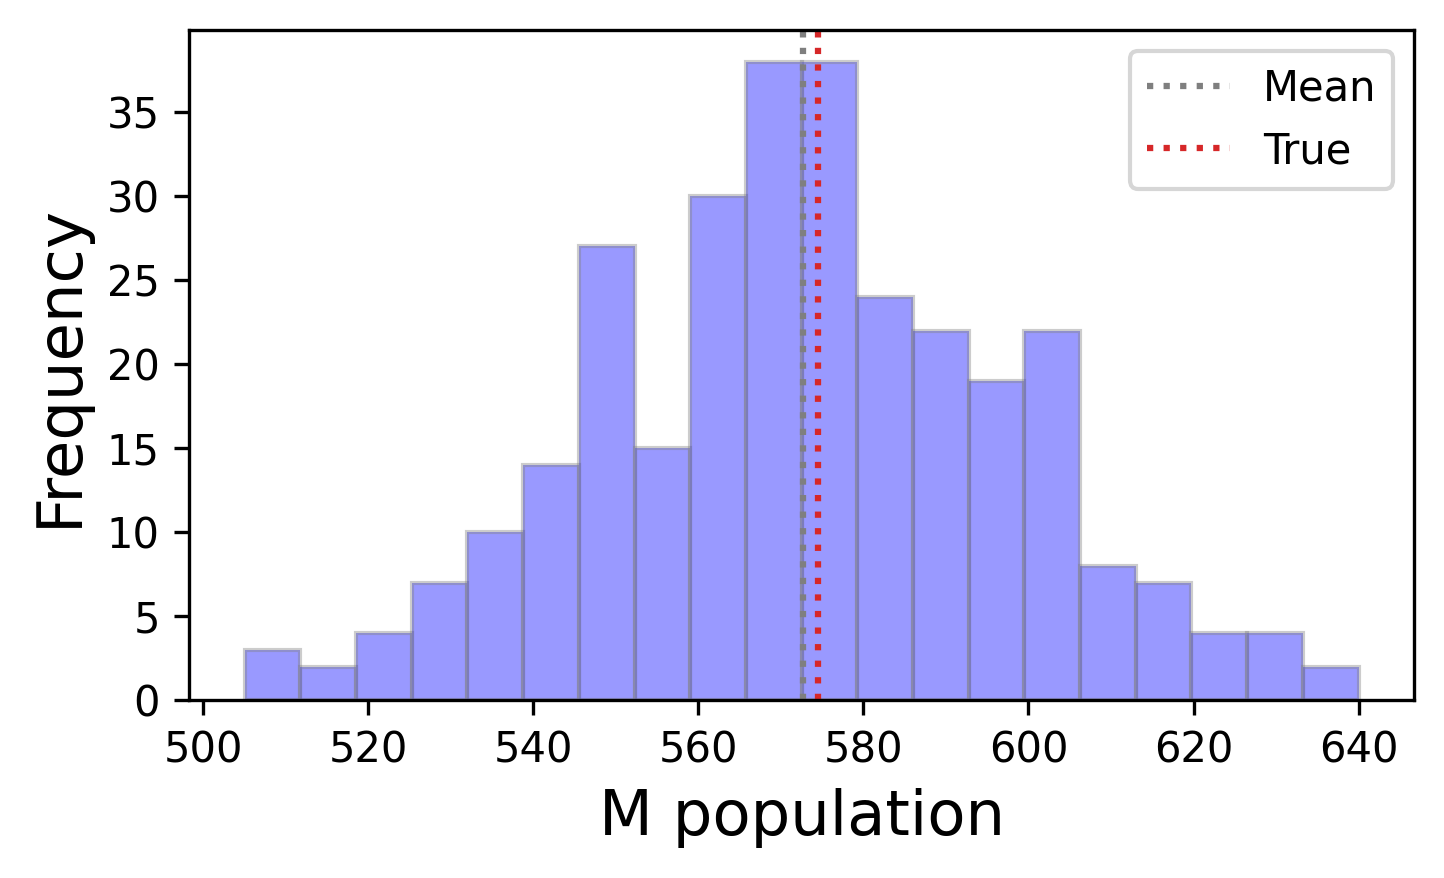

In [57]:
if cycle_model == 0:
    plot_distribution(Ki67_negative_count[:,-1], true_solution[-1,0], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    plot_distribution(Ki67_positive_premitotic_count[:,-1], true_solution[-1,1], r"Ki67$^{+}$ (pre) population", "Ki67_pos_pre_pop")
    plot_distribution(Ki67_positive_postmitotic_count[:,-1], true_solution[-1,2], r"Ki67$^{+}$ (post) population", "Ki67_pos_post_pop")
elif cycle_model == 1:
    plot_distribution(Ki67_negative_count[:,-1], true_solution[-1,0], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    plot_distribution(Ki67_positive_count[:,-1], true_solution[-1,1], r"Ki67$^{+}$ population", "Ki67_pos_pop")
elif cycle_model == 2:
    plot_distribution(G0G1_phase_count[:,-1], true_solution[-1,0], r"G0/G1 population", "G0G1_phase_pop")
    plot_distribution(S_phase_count[:,-1], true_solution[-1,1], r"S population", "S_phase_pop")
    plot_distribution(G2M_phase_count[:,-1], true_solution[-1,2], r"G2/M population", "G2M_phase_pop")
elif cycle_model == 5:
    plot_distribution(live_count[:,-1], true_solution[-1,0], r"Live population", "Live_pop")
elif cycle_model == 6:
    plot_distribution(G0G1_phase_count[:,-1], true_solution[-1,0], r"G0/G1 population", "G0G1_phase_pop")
    plot_distribution(S_phase_count[:,-1], true_solution[-1,1], r"S population", "S_phase_pop")
    plot_distribution(G2_phase_count[:,-1], true_solution[-1,2], r"G2 population", "G2_phase_pop")
    plot_distribution(M_phase_count[:,-1], true_solution[-1,3], r"M population", "M_phase_pop")
else:
    print("Unrecognized cell cycle model.")

## Plot the distribution of the tumor cell fraction at the final simulation time

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

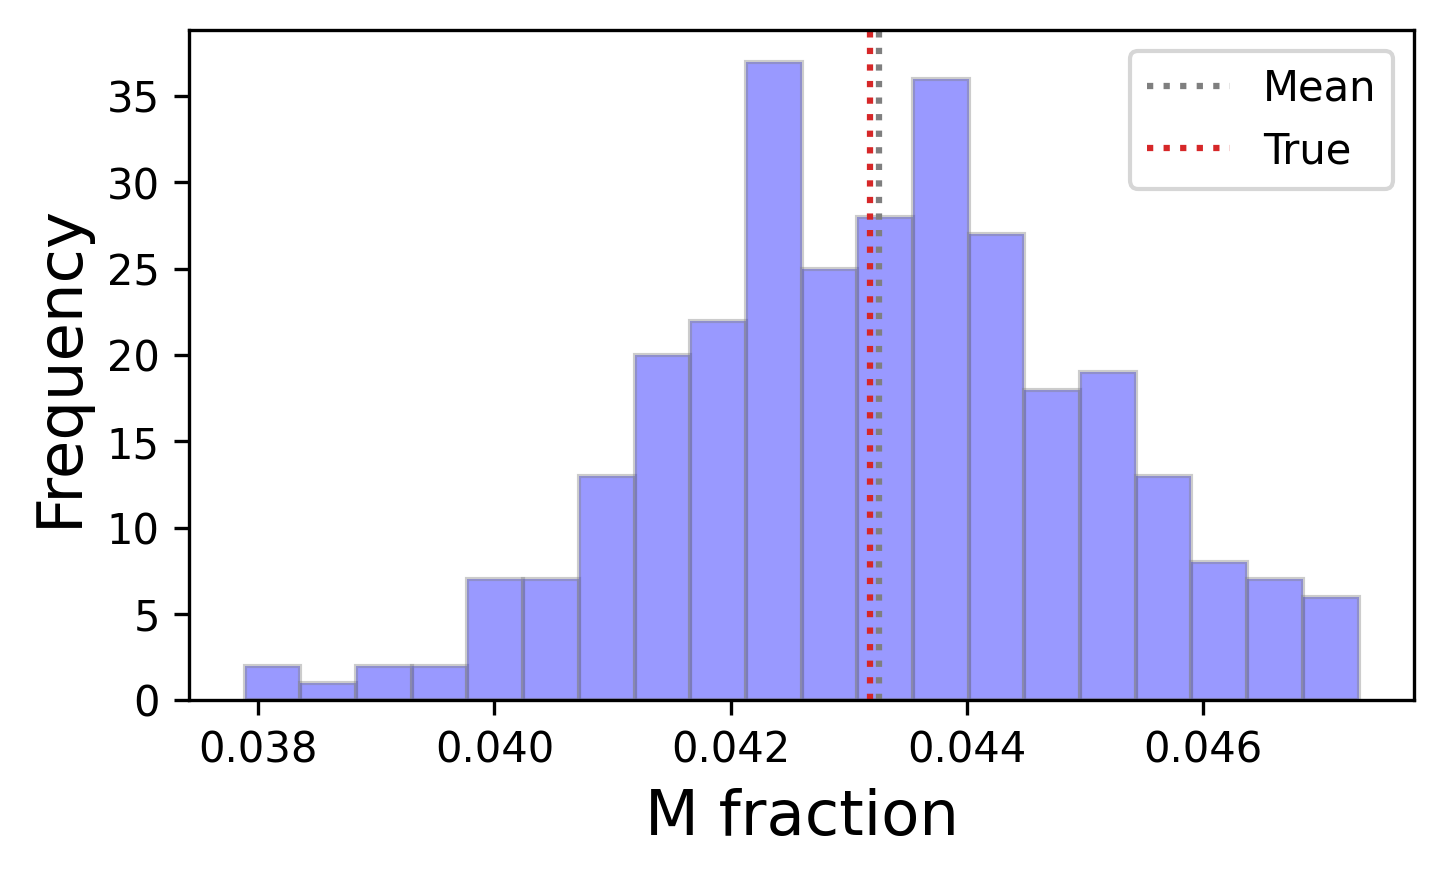

In [58]:
if cycle_model == 0:
    plot_distribution(Ki67_negative_fraction[:,-1], Ki67_negative_true[-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    plot_distribution(Ki67_positive_premitotic_fraction[:,-1], Ki67_positive_premitotic_true[-1], r"Ki67$^{+}$ (pre) fraction", "Ki67_pos_pre_frac")
    plot_distribution(Ki67_positive_postmitotic_fraction[:,-1], Ki67_positive_postmitotic_true[-1], r"Ki67$^{+}$ (post) fraction", "Ki67_pos_post_frac")
elif cycle_model == 1:
    plot_distribution(Ki67_negative_fraction[:,-1], Ki67_negative_true[-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    plot_distribution(Ki67_positive_fraction[:,-1], Ki67_positive_true[-1], r"Ki67$^{+}$ fraction", "Ki67_pos_frac")
elif cycle_model == 2:
    plot_distribution(G0G1_phase_fraction[:,-1], G0G1_phase_true[-1], r"G0/G1 fraction", "G0G1_phase_frac")
    plot_distribution(S_phase_fraction[:,-1], S_phase_true[-1], r"S fraction", "S_phase_frac")
    plot_distribution(G2M_phase_fraction[:,-1], G2M_phase_true[-1], r"G2/M fraction", "G2M_phase_frac")
elif cycle_model == 5:
    plot_distribution(live_fraction[:,-1], live_true[-1], r"Live fraction", "Live_frac")
elif cycle_model == 6:
    plot_distribution(G0G1_phase_fraction[:,-1], G0G1_phase_true[-1], r"G0/G1 fraction", "G0G1_phase_frac")
    plot_distribution(S_phase_fraction[:,-1], S_phase_true[-1], r"S fraction", "S_phase_frac")
    plot_distribution(G2_phase_fraction[:,-1], G2_phase_true[-1], r"G2 fraction", "G2_phase_frac")
    plot_distribution(M_phase_fraction[:,-1], M_phase_true[-1], r"M fraction", "M_phase_frac")
else:
    print("Unrecognized cell cycle model.")

## Find the best distribution that fits the tumor cell population data

In [59]:
def find_best_distribution(data, cell_cycle_phase_title, cell_cycle_phase_filename, distributions_method='custom', bins=10, Nbest=None):
    df = pd.DataFrame(data)
    if distributions_method == 'all':
        distributions = get_distributions()
        loc = None
        scale = None
    elif distributions_method == 'common':
        distributions = get_common_distributions()
        loc = None
        scale = None
    elif distributions_method == 'custom':
        distributions = ['beta', 'chi2', 'gamma', 'lognorm', 'norm']
        # loc = [np.amin(data), 0.0, np.mean(data), np.log(np.median(data)), np.mean(data), np.amin(data)]
        loc = None
        # scale = [np.amax(data)-np.amin(data), 1.0, np.std(data), np.median(data), np.std(data), np.amax(data)-np.amin(data)]
        scale = None
    else:
        print("Unrecognized distributions method.")
    if Nbest is None:
        Nbest = len(distributions)
    f = Fitter(df, bins=bins, distributions=distributions)
    f.fit(loc=loc, scale=scale)
    
    summary = f.summary(Nbest=Nbest, lw=1)
    print(summary)    
    k = np.zeros(Nbest)
    for i, dist in enumerate(summary.index.tolist()):
        k[i] = int(len(f.fitted_param[dist]))
    new_summary = summary.assign(k=k)
    new_summary.to_csv(os.path.join(output_folder, cell_cycle_phase_filename + "_fit_" + distributions_method + str(bins) + ".csv"))
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.hist(data, bins=bins, edgecolor = 'gray', facecolor='blue', alpha=0.4, density=True)
    x = np.linspace(np.amin(data), np.amax(data), 10000)
    for dist in summary.index.tolist():
        scipy_dist = eval("scipy.stats." + dist)
        plt.plot(x, scipy_dist.pdf(x, *f.fitted_param[dist]), '-', label=dist, alpha=1.0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(False)
    
    plt.xlabel( cell_cycle_phase_title, size=15 ) 
    plt.ylabel( 'Density', size=15 )
    # ax.set_ylim((0.0, 0.0012))
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_fit_" + distributions_method + str(bins) + ".pdf"), bbox_inches = 'tight')
    return new_summary

In [60]:
def compute_AIC(AIC_df):
    AIC = AIC_df.to_numpy()
    AICmin = np.amin(AIC)
    Delta_AIC = AIC - AICmin
    like = np.exp(-0.5*Delta_AIC)
    likesum = np.sum(like)
    AIC_weights = like/likesum
    return AIC_weights

def compute_AICc(AIC_df, k_df):
    AIC = AIC_df.to_numpy()
    k = k_df.to_numpy()
    n = num_replicates
    AICc = AIC + (2.0*k*(k + 1.0))/(n - k - 1.0)
    AICcmin = np.amin(AICc)
    Delta_AICc = AICc - AICcmin
    likec = np.exp(-0.5*Delta_AICc)
    likecsum = np.sum(likec)
    AICc_weights = likec/likecsum
    return AICc_weights

def compute_BIC(BIC_df):
    BIC = BIC_df.to_numpy()
    BICmin = np.amin(BIC)
    Delta_BIC = BIC - BICmin
    BICsum = np.sum(np.exp(-0.5*Delta_BIC))
    BIC_prob = np.exp(-0.5*Delta_BIC)/BICsum
    return BIC_prob

In [61]:
def compute_weights(summary, cell_cycle_phase_filename, distributions_method='custom', bins=10):
    df = summary.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['aic', 'bic'], axis=0, inplace=True)
    candidate_models = list(df.index)
    
    AIC_weights = compute_AIC(df['aic'])
    best_AIC_model_index = np.argmax(AIC_weights)
    best_AIC_model = candidate_models[best_AIC_model_index]
    print("Best AIC model = " + best_AIC_model)
    
    AICc_weights = compute_AICc(df['aic'], df['k'])
    best_AICc_model_index = np.argmax(AICc_weights)
    best_AICc_model = candidate_models[best_AICc_model_index]
    print("Best AICc model = " + best_AICc_model)
    
    BIC_prob = compute_BIC(df['bic'])
    best_BIC_model_index = np.argmax(BIC_prob)
    best_BIC_model = candidate_models[best_BIC_model_index]
    print("Best BIC model = " + best_BIC_model)
    
    weights_summary = pd.DataFrame(data = np.stack((df['k'].to_numpy(), df['sumsquare_error'].to_numpy(), AIC_weights, AICc_weights, BIC_prob), axis=1), 
                                   index = candidate_models, 
                                   columns = ['k', 'sumsquare_error', 'AIC_weights', 'AICc_weights', 'BIC_prob']
    )
    print(weights_summary)
    weights_summary.to_csv(os.path.join(output_folder, cell_cycle_phase_filename + "_fit_" + distributions_method + str(bins) + "_weights.csv"))
    return weights_summary

In [62]:
def plot_pareto_curve(weights_summary, cell_cycle_phase_filename, distributions_method='custom', bins=10):
    k = weights_summary['k'].to_numpy()
    sumsquare_error = weights_summary['sumsquare_error'].to_numpy()
    best_AICc_model = np.argmax(weights_summary['AICc_weights'].to_numpy())
    best_BIC_model = np.argmax(weights_summary['BIC_prob'].to_numpy())
    candidate_models = list(weights_summary.index)
    
    other_k = np.delete(k, [best_AICc_model, best_BIC_model])
    other_sumsquare_error = np.delete(sumsquare_error, [best_AICc_model, best_BIC_model])
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.plot(k[best_AICc_model], sumsquare_error[best_AICc_model], "ro", label = r"Best AIC$_c$ distribution", alpha = 0.5, markersize = 5)
    plt.plot(k[best_BIC_model], sumsquare_error[best_BIC_model], "go", label = r"Best BIC distribution", alpha = 0.5, markersize = 5)
    plt.plot(other_k, other_sumsquare_error, "bo", label = "Other distributions", alpha = 0.5, markersize = 5)
    plt.legend()
    
    texts = [plt.text(k[i], sumsquare_error[i], candidate_models[i]) for i in range(len(k))]
    adjust_text(texts, expand_points=(1.5, 1.5))
    
    plt.xlabel( 'Number of parameters', size=15 )
    plt.xticks( range(0, int(np.amax(k))+1, 1) )
    plt.ylabel( 'SSE', size=15 )
    # plt.yscale( 'log' )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_fit_" + distributions_method + str(bins) + "_pareto.pdf"), bbox_inches = 'tight')

In [63]:
def plot_weights(weights_summary, cell_cycle_phase_filename, distributions_method='custom', bins=10):
    bar_width = 0.15
    ticks_factor = 2
    
    num_models = len(weights_summary.index)
    AIC_weights = weights_summary['AIC_weights'].to_numpy()
    AICc_weights = weights_summary['AICc_weights'].to_numpy()
    BIC_prob = weights_summary['BIC_prob'].to_numpy()
    candidate_models = list(weights_summary.index)
    
    bar_data = [None] * num_models
    for i in range(num_models):
        bar_data[i] = np.array([AIC_weights[i], AICc_weights[i], BIC_prob[i]])

    bar_pos = [None] * num_models
    bar_pos[0] = np.arange(bar_data[0].size)
    for i in range(1, num_models):
        bar_pos[i] = [x + bar_width for x in bar_pos[i-1]]

    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    for i in range(num_models):
        plt.bar(bar_pos[i], bar_data[i], width=bar_width, edgecolor='grey', label=candidate_models[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # plt.title( 'Error comparison at t=' + str(times[0][-1]) + " min", size=20)
    plt.xticks([r + ticks_factor*bar_width for r in range(bar_data[0].size)], [r"AIC", r"AIC$_c$", r"BIC"])
    plt.xlabel( 'Candidate models', size=15 ) 
    plt.ylabel( 'Weights', size=15 )
    plt.yscale( 'log' )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_fit_" + distributions_method + str(bins) + "_weights.pdf"), bbox_inches = 'tight')

*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Success = True
Message = Optimization terminated successfully.
*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Restart = 4
Restart = 5
Restart = 6
Restart = 7
Restart = 8
Restart = 9
Restart = 10
Restart = 11
Restart = 12
Restart = 13
Restart = 14
Restart = 15
Success = True
Message = Optimization terminated successfully.
*** Using Differential Evolution method ***

Restart = 1
Success = False
Message = Maximum number of iterations has been exceeded.
*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Restart = 4
Restart = 5
Restart = 6
Restart = 7
Restart = 8
Restart = 9
Restart = 10
Restart = 11
Restart = 12
Restart = 13
Restart = 14
Restart = 15
Success = True
Message = Optimization terminated successfully.
         sumsquare_error          aic          bic    kl_div  ks_statistic  \
norm        2.361414e-07 -6284.785320 -6277.377755  0.00896

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

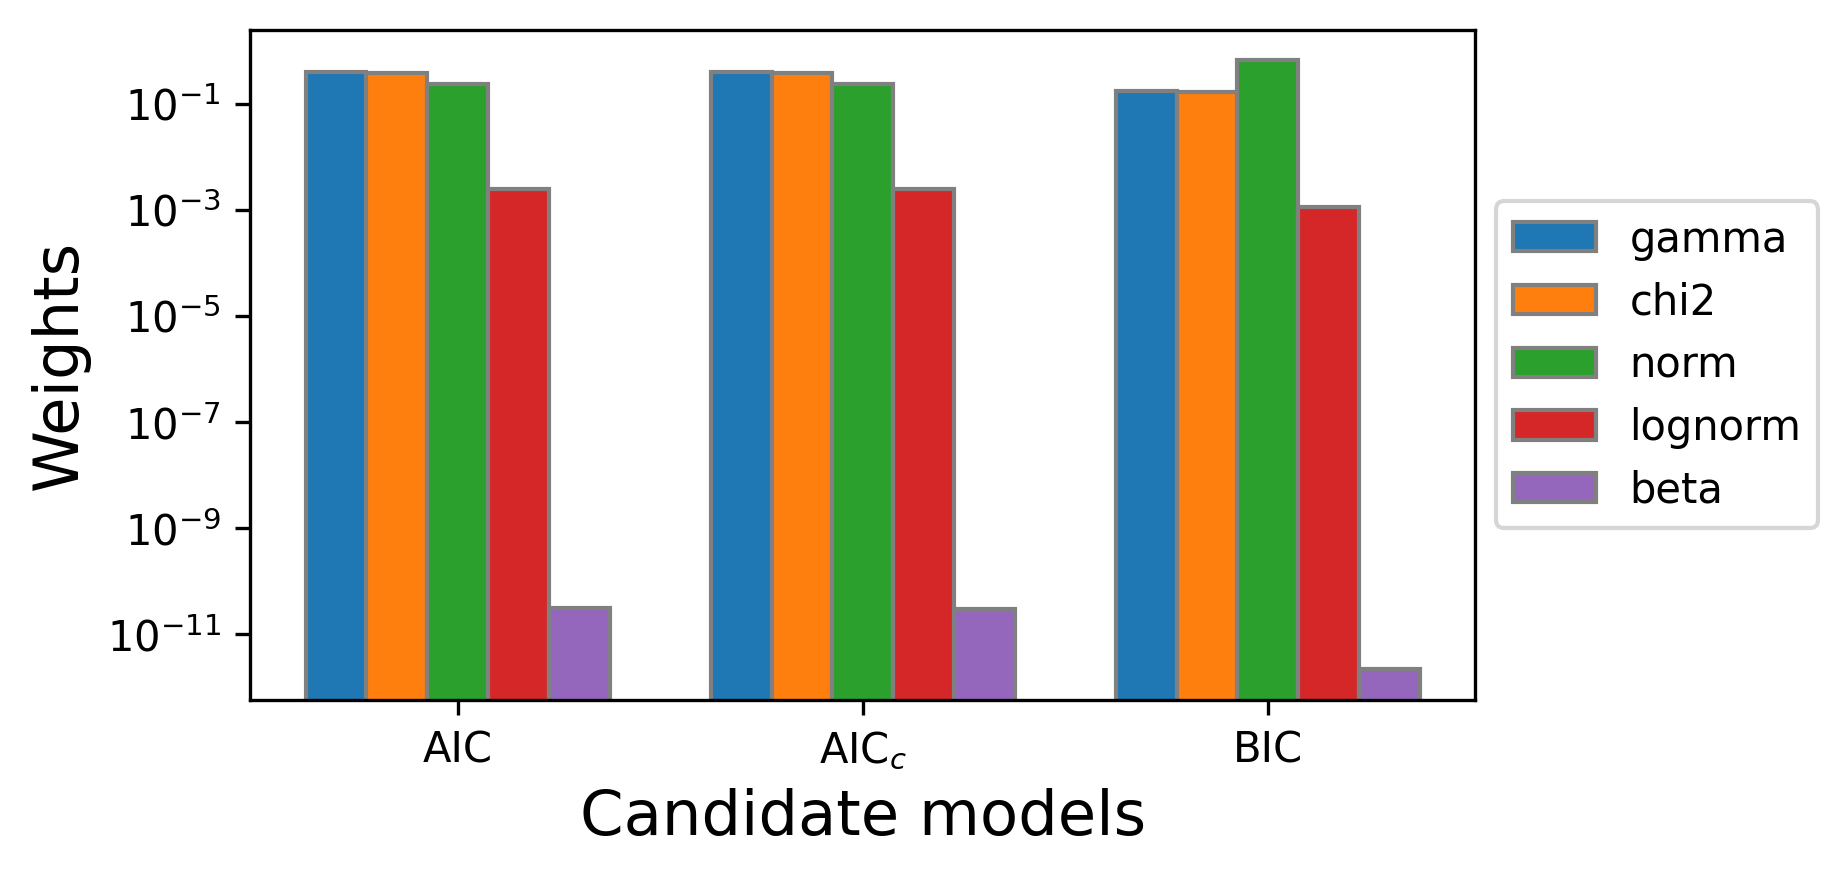

In [64]:
if cycle_model == 0:
    summary = find_best_distribution(Ki67_negative_count[:,-1], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    weights_summary = compute_weights(summary, "Ki67_neg_pop")
    plot_pareto_curve(weights_summary, "Ki67_neg_pop")
    plot_weights(weights_summary, "Ki67_neg_pop")
    
    summary = find_best_distribution(Ki67_positive_premitotic_count[:,-1], r"Ki67$^{+}$ (pre) population", "Ki67_pos_pre_pop")
    weights_summary = compute_weights(summary, "Ki67_pos_pre_pop")
    plot_pareto_curve(weights_summary, "Ki67_pos_pre_pop")
    plot_weights(weights_summary, "Ki67_pos_pre_pop")
    
    summary = find_best_distribution(Ki67_positive_postmitotic_count[:,-1], r"Ki67$^{+}$ (post) population", "Ki67_pos_post_pop")
    weights_summary = compute_weights(summary, "Ki67_pos_post_pop")
    plot_pareto_curve(weights_summary, "Ki67_pos_post_pop")
    plot_weights(weights_summary, "Ki67_pos_post_pop")
elif cycle_model == 1:
    summary = find_best_distribution(Ki67_negative_count[:,-1], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    weights_summary = compute_weights(summary, "Ki67_neg_pop")
    plot_pareto_curve(weights_summary, "Ki67_neg_pop")
    plot_weights(weights_summary, "Ki67_neg_pop")
    
    summary = find_best_distribution(Ki67_positive_count[:,-1], r"Ki67$^{+}$ population", "Ki67_pos_pop")
    weights_summary = compute_weights(summary, "Ki67_pos_pop")
    plot_pareto_curve(weights_summary, "Ki67_pos_pop")
    plot_weights(weights_summary, "Ki67_pos_pop")
elif cycle_model == 2:
    summary = find_best_distribution(G0G1_phase_count[:,-1], r"G0/G1 population", "G0G1_phase_pop")
    weights_summary = compute_weights(summary, "G0G1_phase_pop")
    plot_pareto_curve(weights_summary, "G0G1_phase_pop")
    plot_weights(weights_summary, "G0G1_phase_pop")
    
    summary = find_best_distribution(S_phase_count[:,-1], r"S population", "S_phase_pop")
    weights_summary = compute_weights(summary, "S_phase_pop")
    plot_pareto_curve(weights_summary, "S_phase_pop")
    plot_weights(weights_summary, "S_phase_pop")
    
    summary = find_best_distribution(G2M_phase_count[:,-1], r"G2/M population", "G2M_phase_pop")
    weights_summary = compute_weights(summary, "G2M_phase_pop")
    plot_pareto_curve(weights_summary, "G2M_phase_pop")
    plot_weights(weights_summary, "G2M_phase_pop")
elif cycle_model == 5:
    summary = find_best_distribution(live_count[:,-1], r"Live population", "live_pop")
    weights_summary = compute_weights(summary, "live_pop")
    plot_pareto_curve(weights_summary, "live_pop")
    plot_weights(weights_summary, "live_pop")
elif cycle_model == 6:
    summary = find_best_distribution(G0G1_phase_count[:,-1], r"G0/G1 population", "G0G1_phase_pop")
    weights_summary = compute_weights(summary, "G0G1_phase_pop")
    plot_pareto_curve(weights_summary, "G0G1_phase_pop")
    plot_weights(weights_summary, "G0G1_phase_pop")
    
    summary = find_best_distribution(S_phase_count[:,-1], r"S population", "S_phase_pop")
    weights_summary = compute_weights(summary, "S_phase_pop")
    plot_pareto_curve(weights_summary, "S_phase_pop")
    plot_weights(weights_summary, "S_phase_pop")
    
    summary = find_best_distribution(G2_phase_count[:,-1], r"G2 population", "G2_phase_pop")
    weights_summary = compute_weights(summary, "G2_phase_pop")
    plot_pareto_curve(weights_summary, "G2_phase_pop")
    plot_weights(weights_summary, "G2_phase_pop")
    
    summary = find_best_distribution(M_phase_count[:,-1], r"M population", "M_phase_pop")
    weights_summary = compute_weights(summary, "M_phase_pop")
    plot_pareto_curve(weights_summary, "M_phase_pop")
    plot_weights(weights_summary, "M_phase_pop")
else:
    print("Unrecognized cell cycle model.")

## Find the best distribution that fits the tumor cell fraction data using Fitter

*** Using Differential Evolution method ***

Restart = 1
Success = True
Message = Optimization terminated successfully.
*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Restart = 4
Restart = 5
Restart = 6
Restart = 7
Restart = 8
Restart = 9
Restart = 10
Restart = 11
Restart = 12
Restart = 13
Restart = 14
Restart = 15
Restart = 16
Restart = 17
Success = True
Message = Optimization terminated successfully.
*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Restart = 4
Restart = 5
Restart = 6
Restart = 7
Success = True
Message = Optimization terminated successfully.
*** Using Differential Evolution method ***

Restart = 1
Restart = 2
Restart = 3
Success = True
Message = Optimization terminated successfully.
         sumsquare_error        aic        bic    kl_div  ks_statistic  \
beta          223.089316 -80.863079 -66.047949  0.008852      0.036385   
norm          312.210115  15.968180  23.375745  0.009511      0.044893   
ga

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

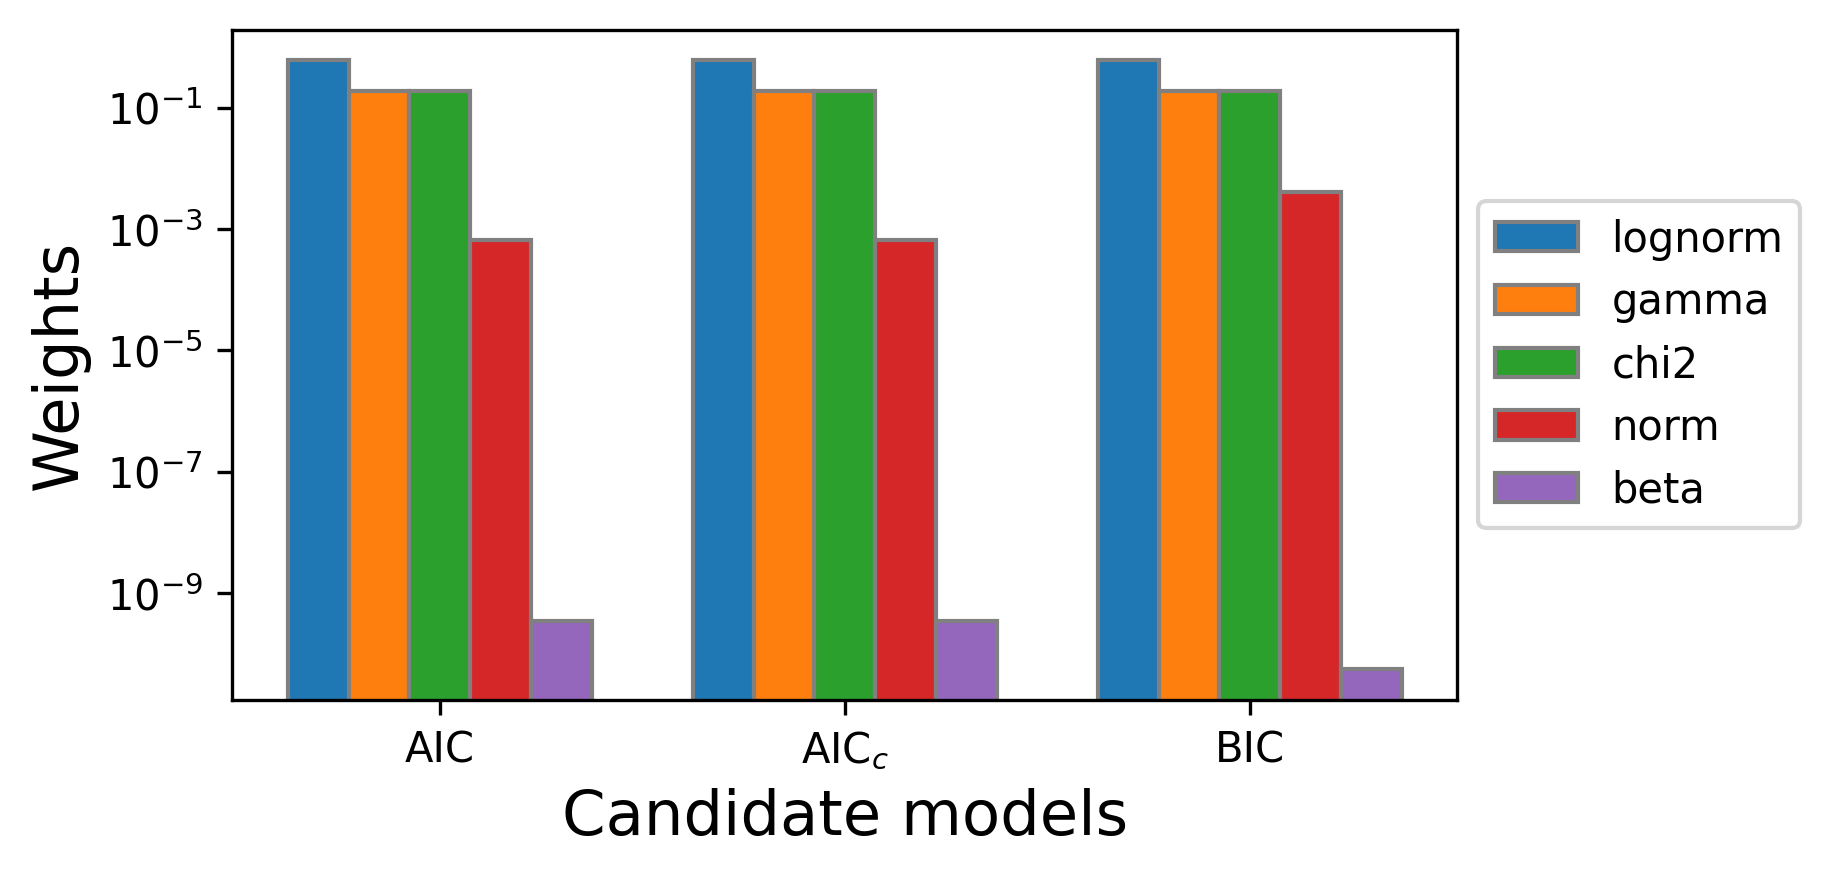

In [65]:
if cycle_model == 0:
    summary = find_best_distribution(Ki67_negative_fraction[:,-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    weights_summary = compute_weights(summary, "Ki67_neg_frac")
    plot_pareto_curve(weights_summary, "Ki67_neg_frac")
    plot_weights(weights_summary, "Ki67_neg_frac")
    
    summary = find_best_distribution(Ki67_positive_premitotic_fraction[:,-1], r"Ki67$^{+}$ (pre) fraction", "Ki67_pos_pre_frac")
    weights_summary = compute_weights(summary, "Ki67_pos_pre_frac")
    plot_pareto_curve(weights_summary, "Ki67_pos_pre_frac")
    plot_weights(weights_summary, "Ki67_pos_pre_frac")
    
    summary = find_best_distribution(Ki67_positive_postmitotic_fraction[:,-1], r"Ki67$^{+}$ (post) fraction", "Ki67_pos_post_frac")
    weights_summary = compute_weights(summary, "Ki67_pos_post_frac")
    plot_pareto_curve(weights_summary, "Ki67_pos_post_frac")
    plot_weights(weights_summary, "Ki67_pos_post_frac")
elif cycle_model == 1:
    summary = find_best_distribution(Ki67_negative_fraction[:,-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    weights_summary = compute_weights(summary, "Ki67_neg_frac")
    plot_pareto_curve(weights_summary, "Ki67_neg_frac")
    plot_weights(weights_summary, "Ki67_neg_frac")
    
    summary = find_best_distribution(Ki67_positive_fraction[:,-1], r"Ki67$^{+}$ fraction", "Ki67_pos_frac")
    weights_summary = compute_weights(summary, "Ki67_pos_frac")
    plot_pareto_curve(weights_summary, "Ki67_pos_frac")
    plot_weights(weights_summary, "Ki67_pos_frac")
elif cycle_model == 2:
    summary = find_best_distribution(G0G1_phase_fraction[:,-1], r"G0/G1 fraction", "G0G1_phase_frac")
    weights_summary = compute_weights(summary, "G0G1_phase_frac")
    plot_pareto_curve(weights_summary, "G0G1_phase_frac")
    plot_weights(weights_summary, "G0G1_phase_frac")
    
    summary = find_best_distribution(S_phase_fraction[:,-1], r"S fraction", "S_phase_frac")
    weights_summary = compute_weights(summary, "S_phase_frac")
    plot_pareto_curve(weights_summary, "S_phase_frac")
    plot_weights(weights_summary, "S_phase_frac")
    
    summary = find_best_distribution(G2M_phase_fraction[:,-1], r"G2/M fraction", "G2M_phase_frac")
    weights_summary = compute_weights(summary, "G2M_phase_frac")
    plot_pareto_curve(weights_summary, "G2M_phase_frac")
    plot_weights(weights_summary, "G2M_phase_frac")
elif cycle_model == 5:
    summary = find_best_distribution(live_fraction[:,-1], r"Live fraction", "live_frac")
    weights_summary = compute_weights(summary, "live_frac")
    plot_pareto_curve(weights_summary, "live_frac")
    plot_weights(weights_summary, "live_frac")
elif cycle_model == 6:
    summary = find_best_distribution(G0G1_phase_fraction[:,-1], r"G0/G1 fraction", "G0G1_phase_frac")
    weights_summary = compute_weights(summary, "G0G1_phase_frac")
    plot_pareto_curve(weights_summary, "G0G1_phase_frac")
    plot_weights(weights_summary, "G0G1_phase_frac")
    
    summary = find_best_distribution(S_phase_fraction[:,-1], r"S fraction", "S_phase_frac")
    weights_summary = compute_weights(summary, "S_phase_frac")
    plot_pareto_curve(weights_summary, "S_phase_frac")
    plot_weights(weights_summary, "S_phase_frac")
    
    summary = find_best_distribution(G2_phase_fraction[:,-1], r"G2 fraction", "G2_phase_frac")
    weights_summary = compute_weights(summary, "G2_phase_frac")
    plot_pareto_curve(weights_summary, "G2_phase_frac")
    plot_weights(weights_summary, "G2_phase_frac")
    
    summary = find_best_distribution(M_phase_fraction[:,-1], r"M fraction", "M_phase_frac")
    weights_summary = compute_weights(summary, "M_phase_frac")
    plot_pareto_curve(weights_summary, "M_phase_frac")
    plot_weights(weights_summary, "M_phase_frac")
else:
    print("Unrecognized cell cycle model.")

## Find the best distribution that fits the tumor cell population data using distfit

In [66]:
def find_best_distribution(data, cell_cycle_phase_title, cell_cycle_phase_filename, distributions_method='custom', bins=10, Nbest=None):
    if distributions_method == 'all':
        distributions = 'full'
        if Nbest is None:
            Nbest = 85
    elif distributions_method == 'common':
        distributions = 'popular'
        if Nbest is None:
            Nbest = 10
    elif distributions_method == 'custom':
        distributions = ['beta', 'chi2', 'gamma', 'lognorm', 'norm']
        if Nbest is None:
            Nbest = len(distributions)
    else:
        print("Unrecognized distributions method.")
    dfit = distfit(distr=distributions, bins=bins)
    results = dfit.fit_transform(data)
    
    n = len(data)
    sq_error = results['summary']['score'].to_numpy().astype(float)
    k = np.zeros(Nbest)
    for i, params in enumerate(results['summary']['params']):
        k[i] = len(params)
    aic = 2 * k + n * np.log(sq_error / n)
    bic = n * np.log(sq_error / n) + k * np.log(n)
    
    new_summary = results['summary'].assign(k=k, aic=aic, bic=bic)
    new_summary.to_csv(os.path.join(output_folder, cell_cycle_phase_filename + "_distfit.csv"))
    
    dfit.predict(data)
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    dfit.plot(chart='pdf', n_top=Nbest, ax=ax,
             bar_properties={'edgecolor': 'gray', 'facecolor': 'blue', 'alpha': 0.4},
             pdf_properties={'linewidth': 1},
             emp_properties=None,
             cii_properties=None)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(False)
    
    plt.xlabel( cell_cycle_phase_title, size=15 ) 
    plt.ylabel( 'Density', size=15 )
    plt.title( '' )
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_distfit.pdf"), bbox_inches = 'tight')
    return new_summary

In [67]:
def compute_weights(summary, cell_cycle_phase_filename, distributions_method='custom', bins=10):
    df = summary.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['aic', 'bic'], axis=0, inplace=True)
    candidate_models = df['name']
    
    AIC_weights = compute_AIC(df['aic'])
    best_AIC_model_index = np.argmax(AIC_weights)
    best_AIC_model = candidate_models[best_AIC_model_index]
    print("Best AIC model = " + best_AIC_model)
    
    AICc_weights = compute_AICc(df['aic'], df['k'])
    best_AICc_model_index = np.argmax(AICc_weights)
    best_AICc_model = candidate_models[best_AICc_model_index]
    print("Best AICc model = " + best_AICc_model)
    
    BIC_prob = compute_BIC(df['bic'])
    best_BIC_model_index = np.argmax(BIC_prob)
    best_BIC_model = candidate_models[best_BIC_model_index]
    print("Best BIC model = " + best_BIC_model)
    
    weights_summary = pd.DataFrame(data = np.stack((AIC_weights, AICc_weights, BIC_prob), axis=1), 
                                   index = candidate_models, 
                                   columns = ['AIC_weights', 'AICc_weights', 'BIC_prob']
    )
    print(weights_summary)
    weights_summary.to_csv(os.path.join(output_folder, cell_cycle_phase_filename + "_distfit_weights.csv"))

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.13 sec] [RSS: 3.87683e-07] [loc=3126.578 scale=5142693.994]
[distfit] >INFO> [chi2   ] [0.08 sec] [RSS: 1.16356e-06] [loc=4135.334 scale=8.976]
[distfit] >INFO> [gamma  ] [0.07 sec] [RSS: 2.63611e-07] [loc=-1820.787 scale=1.433]
[distfit] >INFO> [lognorm] [0.10 sec] [RSS: 5.0123e-05] [loc=4416.000 scale=3.823]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 2.36141e-07] [loc=4689.973 scale=96.578]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:4689.973333, scale:96.577979)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.07 sec] [RSS: 7.20699e-07] [loc=5109.511 scale=908.874]


Best AIC model = norm
Best AICc model = norm
Best BIC model = norm
           AIC_weights   AICc_weights       BIC_prob
name                                                
norm      1.000000e+00   1.000000e+00   1.000000e+00
gamma     2.494349e-08   2.444130e-08   3.914633e-09
beta      6.849222e-34   6.530872e-34   1.686976e-35
chi2     4.710735e-105  4.615894e-105  7.393032e-106
lognorm   0.000000e+00   0.000000e+00   0.000000e+00


[distfit] >INFO> [chi2   ] [0.12 sec] [RSS: 4.6532e-05] [loc=5277.000 scale=2.097]
[distfit] >INFO> [gamma  ] [0.09 sec] [RSS: 6.47128e-07] [loc=-1594.281 scale=1.458]
[distfit] >INFO> [lognorm] [0.12 sec] [RSS: 4.5867e-05] [loc=5277.000 scale=0.341]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 6.58942e-07] [loc=5589.813 scale=102.289]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Gamma(loc:-1594.280932, scale:1.458404)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.13 sec] [RSS: 2.11785e-06] [loc=1574.412 scale=1799.528]


Best AIC model = gamma
Best AICc model = gamma
Best BIC model = norm
           AIC_weights   AICc_weights       BIC_prob
name                                                
gamma     8.473185e-01   8.446686e-01   4.655127e-01
norm      1.526815e-01   1.553313e-01   5.344873e-01
beta      3.014084e-08   2.923868e-08   2.598807e-09
lognorm  2.246494e-278  2.239469e-278  1.234213e-278
chi2     2.592971e-279  2.584862e-279  1.424566e-279


[distfit] >INFO> [chi2   ] [0.10 sec] [RSS: 3.37619e-06] [loc=1903.004 scale=3.270]
[distfit] >INFO> [gamma  ] [0.04 sec] [RSS: 2.06713e-06] [loc=-3114.918 scale=0.559]
[distfit] >INFO> [lognorm] [0.10 sec] [RSS: 0.000160767] [loc=2229.000 scale=3.410]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 1.99982e-06] [loc=2385.870 scale=55.464]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Norm(loc:2385.870000, scale:55.464461)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.08 sec] [RSS: 7.89448e-06] [loc=412.770 scale=308.198]


Best AIC model = norm
Best AICc model = norm
Best BIC model = norm
           AIC_weights   AICc_weights       BIC_prob
name                                                
norm      9.974160e-01   9.974685e-01   9.995969e-01
gamma     2.559223e-03   2.507830e-03   4.025228e-04
beta      2.481959e-05   2.366723e-05   6.126477e-07
chi2      2.813338e-35   2.756843e-35   4.424910e-36
lognorm  6.075784e-287  5.953773e-287  9.556189e-288


[distfit] >INFO> [chi2   ] [0.10 sec] [RSS: 1.21786e-05] [loc=419.516 scale=2.230]
[distfit] >INFO> [gamma  ] [0.11 sec] [RSS: 6.79247e-06] [loc=-1793.526 scale=0.263]
[distfit] >INFO> [lognorm] [0.08 sec] [RSS: 0.000911756] [loc=505.000 scale=3.891]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 6.87573e-06] [loc=572.693 scale=24.920]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Gamma(loc:-1793.526392, scale:0.262530)


Best AIC model = gamma
Best AICc model = gamma
Best BIC model = norm
           AIC_weights   AICc_weights       BIC_prob
name                                                
gamma     6.958306e-01   6.915089e-01   2.641771e-01
norm      3.041694e-01   3.084911e-01   7.358229e-01
beta      4.110107e-11   3.974753e-11   2.448943e-12
chi2      6.416384e-39   6.376533e-39   2.436027e-39
lognorm  4.621984e-320  4.593328e-320  1.754921e-320


<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

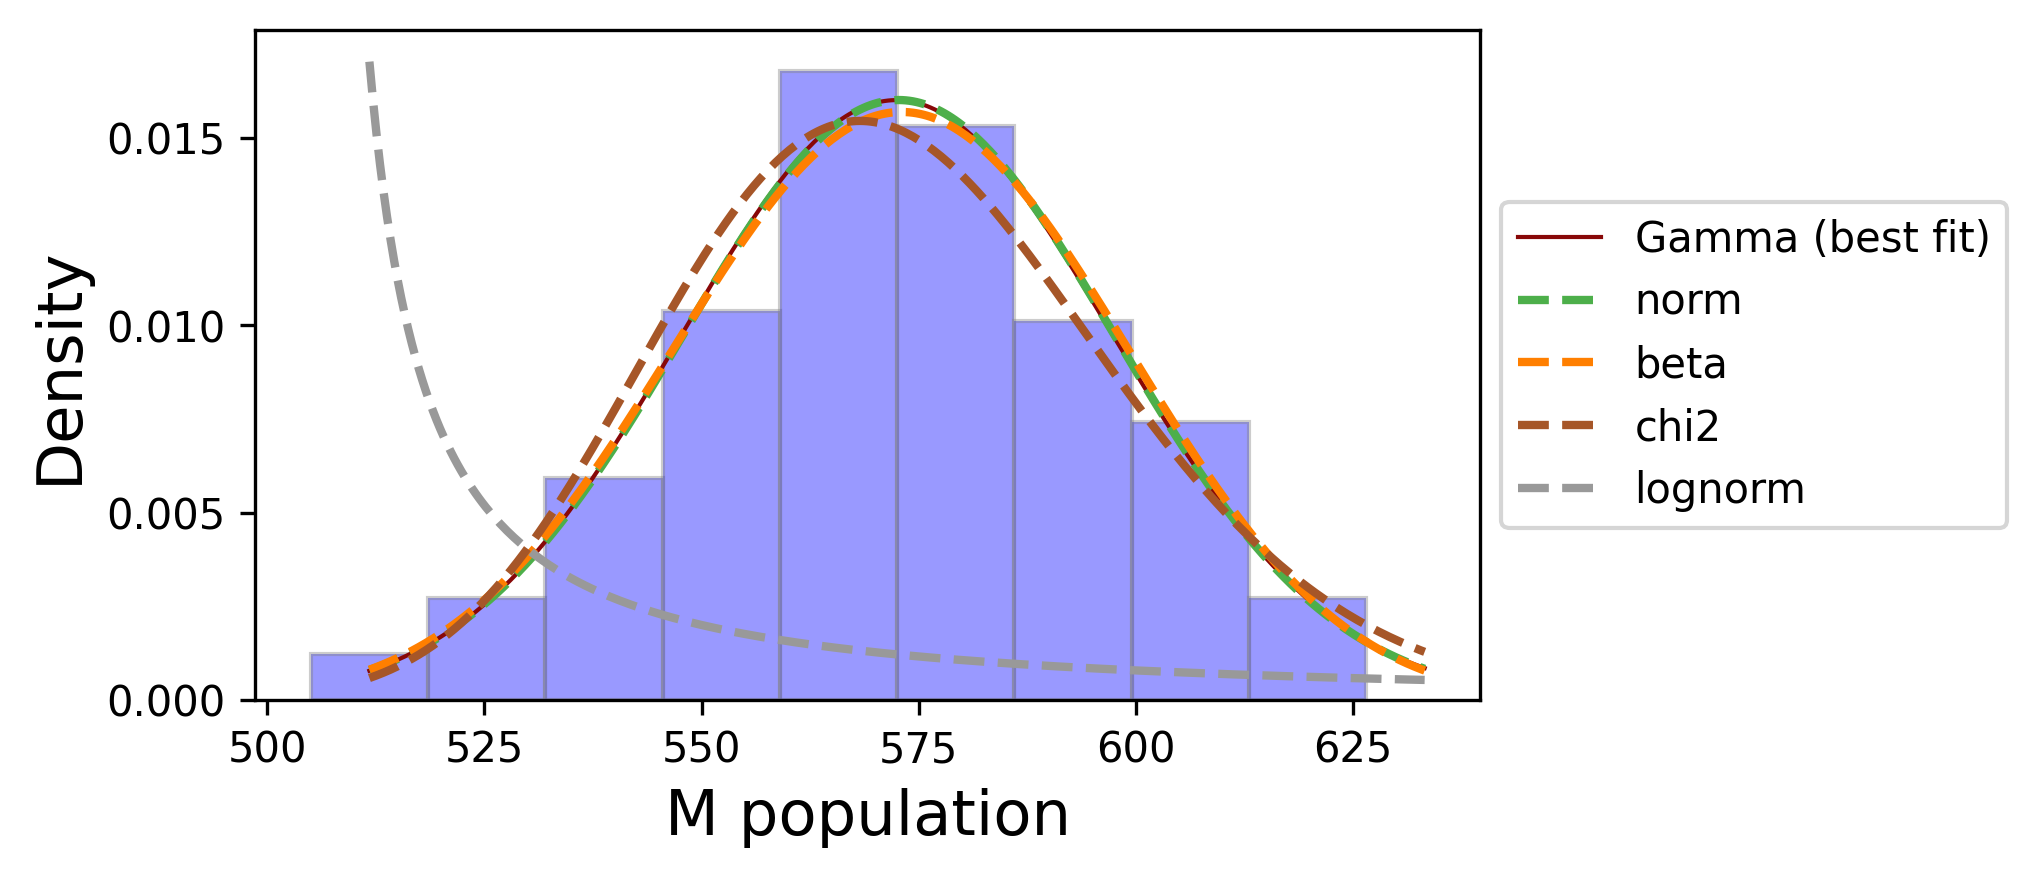

In [68]:
if cycle_model == 0:
    summary = find_best_distribution(Ki67_negative_count[:,-1], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    compute_weights(summary, "Ki67_neg_pop")
    summary = find_best_distribution(Ki67_positive_premitotic_count[:,-1], r"Ki67$^{+}$ (pre) population", "Ki67_pos_pre_pop")
    compute_weights(summary, "Ki67_pos_pre_pop")
    summary = find_best_distribution(Ki67_positive_postmitotic_count[:,-1], r"Ki67$^{+}$ (post) population", "Ki67_pos_post_pop")
    compute_weights(summary, "Ki67_pos_post_pop")
elif cycle_model == 1:
    summary = find_best_distribution(Ki67_negative_count[:,-1], r"Ki67$^{-}$ population", "Ki67_neg_pop")
    compute_weights(summary, "Ki67_neg_pop")
    summary = find_best_distribution(Ki67_positive_count[:,-1], r"Ki67$^{+}$ population", "Ki67_pos_pop")
    compute_weights(summary, "Ki67_pos_pop")
elif cycle_model == 2:
    summary = find_best_distribution(G0G1_phase_count[:,-1], r"G0/G1 population", "G0G1_phase_pop")
    compute_weights(summary, "G0G1_phase_pop")
    summary = find_best_distribution(S_phase_count[:,-1], r"S population", "S_phase_pop")
    compute_weights(summary, "S_phase_pop")
    summary = find_best_distribution(G2M_phase_count[:,-1], r"G2/M population", "G2M_phase_pop")
    compute_weights(summary, "G2M_phase_pop")
elif cycle_model == 5:
    summary = find_best_distribution(live_count[:,-1], r"Live population", "live_pop")
    compute_weights(summary, "live_pop")
elif cycle_model == 6:
    summary = find_best_distribution(G0G1_phase_count[:,-1], r"G0/G1 population", "G0G1_phase_pop")
    compute_weights(summary, "G0G1_phase_pop")
    summary = find_best_distribution(S_phase_count[:,-1], r"S population", "S_phase_pop")
    compute_weights(summary, "S_phase_pop")
    summary = find_best_distribution(G2_phase_count[:,-1], r"G2 population", "G2_phase_pop")
    compute_weights(summary, "G2_phase_pop")
    summary = find_best_distribution(M_phase_count[:,-1], r"M population", "M_phase_pop")
    compute_weights(summary, "M_phase_pop")
else:
    print("Unrecognized cell cycle model.")

## Find the best distribution that fits the tumor cell fraction data using distfit

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.07 sec] [RSS: 223.09] [loc=0.321 scale=0.056]
[distfit] >INFO> [chi2   ] [0.07 sec] [RSS: 22156.6] [loc=0.341 scale=1.291]
[distfit] >INFO> [gamma  ] [0.11 sec] [RSS: 370.355] [loc=0.242 scale=0.000]
[distfit] >INFO> [lognorm] [0.33 sec] [RSS: 341.001] [loc=0.044 scale=0.310]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 312.21] [loc=0.354 scale=0.004]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.321048, scale:0.056032)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.05 sec] [RSS: 741.512] [loc=0.409 scale=0.028]
[distfit] >INFO> [chi2   ] [0.06 sec] [RSS: 24990.5] [loc=0.411 scale=1.156]


Best AIC model = beta
Best AICc model = beta
Best BIC model = beta
           AIC_weights   AICc_weights       BIC_prob
name                                                
beta      1.000000e+00   1.000000e+00   1.000000e+00
norm      9.409159e-22   9.867812e-22   3.820174e-20
lognorm   6.207609e-28   6.379131e-28   3.955401e-27
gamma     2.591566e-33   2.663174e-33   1.651310e-32
chi2     7.601187e-300  7.811214e-300  4.843369e-299


[distfit] >INFO> [gamma  ] [0.10 sec] [RSS: 839.72] [loc=0.342 scale=0.000]
[distfit] >INFO> [lognorm] [0.18 sec] [RSS: 842.259] [loc=0.317 scale=0.105]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 843.73] [loc=0.422 scale=0.004]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.408935, scale:0.028094)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.08 sec] [RSS: 170.572] [loc=0.114 scale=17069.765]


Best AIC model = beta
Best AICc model = beta
Best BIC model = beta
           AIC_weights   AICc_weights       BIC_prob
name                                                
beta      9.999999e-01   9.999999e-01   9.999986e-01
gamma     2.147149e-08   2.206477e-08   1.368131e-07
lognorm   1.365101e-08   1.402820e-08   8.698217e-08
norm      2.856299e-08   2.995530e-08   1.159673e-06
chi2     1.931105e-229  1.984463e-229  1.230471e-228


[distfit] >INFO> [chi2   ] [0.13 sec] [RSS: 34551.4] [loc=0.171 scale=1.154]
[distfit] >INFO> [gamma  ] [0.06 sec] [RSS: 172.517] [loc=0.109 scale=0.000]
[distfit] >INFO> [lognorm] [0.16 sec] [RSS: 173.402] [loc=0.074 scale=0.106]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 215.45] [loc=0.180 scale=0.003]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.113712, scale:17069.764981)
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta   ] [0.06 sec] [RSS: 2985.82] [loc=0.032 scale=0.020]
[distfit] >INFO> [chi2   ] [0.06 sec] [RSS: 151221] [loc=0.038 scale=1.321]


Best AIC model = beta
Best AICc model = beta
Best BIC model = gamma
          AIC_weights  AICc_weights      BIC_prob
name                                             
beta     5.791864e-01  5.725293e-01  1.776345e-01
gamma    2.873846e-01  2.919308e-01  5.616148e-01
lognorm  1.334291e-01  1.355398e-01  2.607507e-01
norm     2.603607e-15  2.699137e-15  3.242028e-14
chi2     0.000000e+00  0.000000e+00  0.000000e+00


[distfit] >INFO> [gamma  ] [0.10 sec] [RSS: 2645.54] [loc=-0.007 scale=0.000]
[distfit] >INFO> [lognorm] [0.16 sec] [RSS: 2718.06] [loc=-0.133 scale=0.176]
[distfit] >INFO> [norm   ] [0.00 sec] [RSS: 2748.05] [loc=0.043 scale=0.002]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 300 samples.
[distfit] >INFO> Multiple test correction method applied: [fdr_bh].
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Gamma(loc:-0.007264, scale:0.000062)


Best AIC model = gamma
Best AICc model = gamma
Best BIC model = gamma
           AIC_weights   AICc_weights       BIC_prob
name                                                
gamma     9.742897e-01   9.741128e-01   9.301139e-01
lognorm   1.686879e-02   1.686572e-02   1.610393e-02
norm      8.841469e-03   9.021493e-03   5.378220e-02
beta      4.699113e-09   4.571933e-09   7.040407e-10
chi2     2.654320e-264  2.653838e-264  2.533969e-264


<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

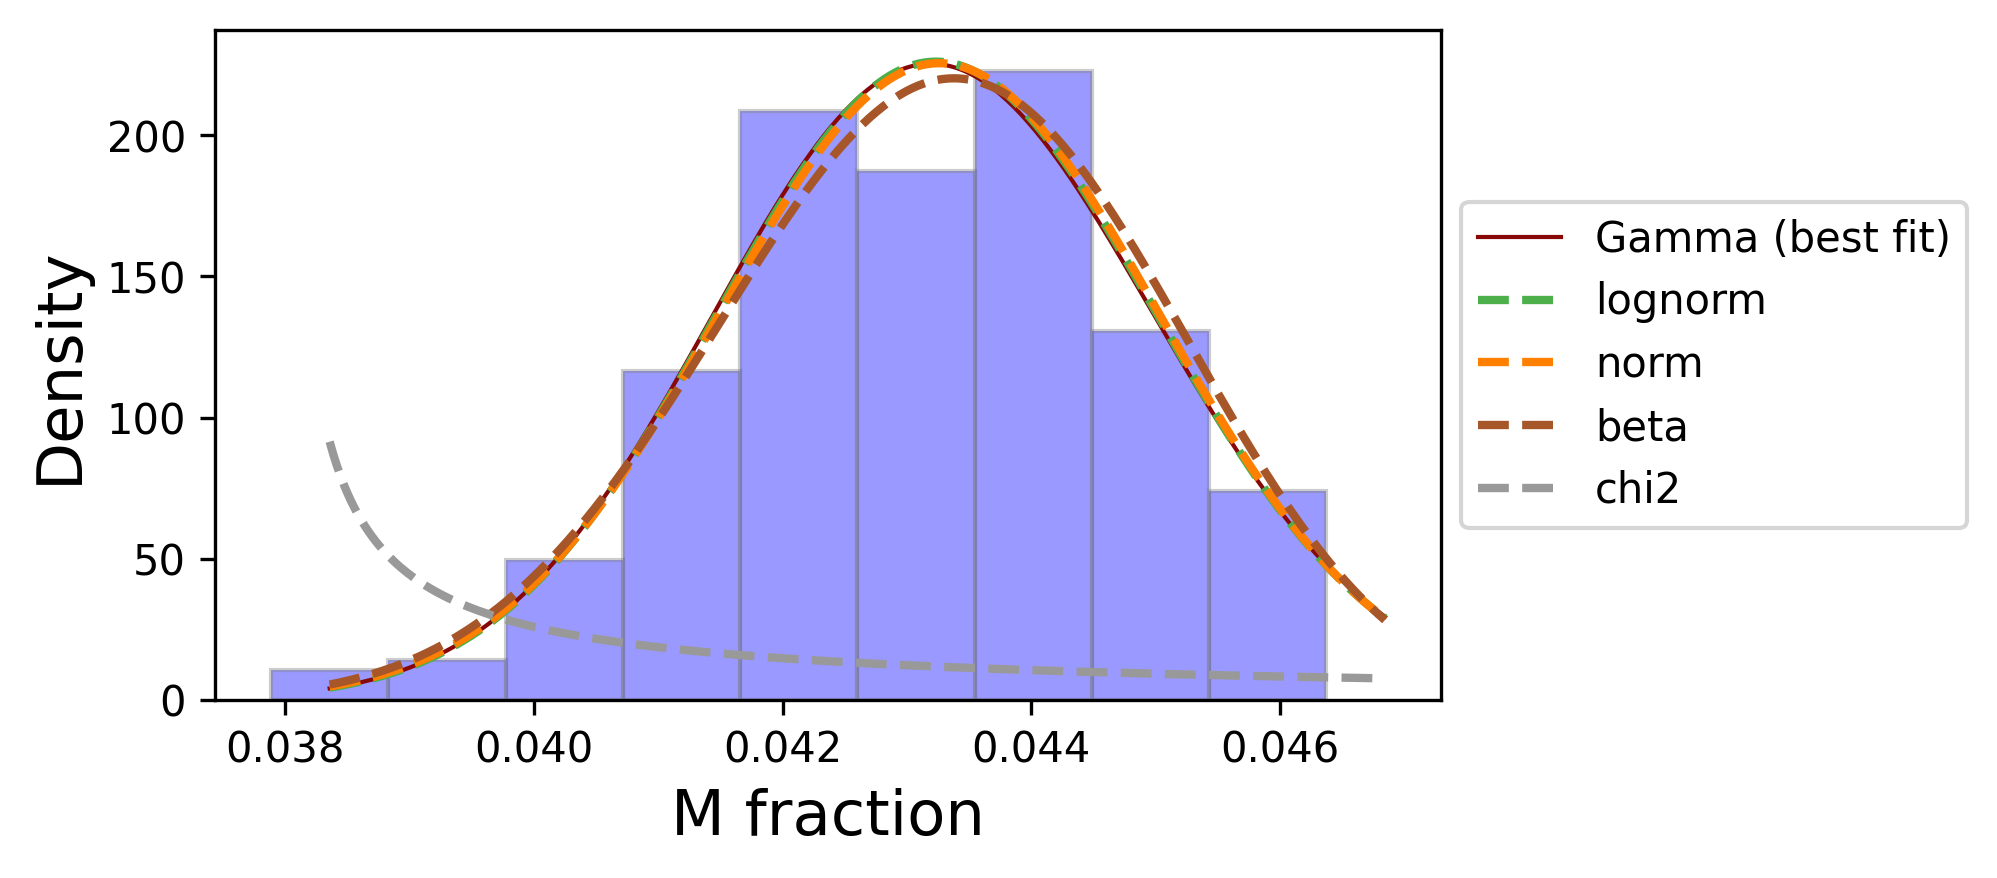

In [69]:
if cycle_model == 0:
    summary = find_best_distribution(Ki67_negative_fraction[:,-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    compute_weights(summary, "Ki67_neg_frac")
    summary = find_best_distribution(Ki67_positive_premitotic_fraction[:,-1], r"Ki67$^{+}$ (pre) fraction", "Ki67_pos_pre_frac")
    compute_weights(summary, "Ki67_pos_pre_frac")
    summary = find_best_distribution(Ki67_positive_postmitotic_fraction[:,-1], r"Ki67$^{+}$ (post) fraction", "Ki67_pos_post_frac")
    compute_weights(summary, "Ki67_pos_post_frac")
elif cycle_model == 1:
    summary = find_best_distribution(Ki67_negative_fraction[:,-1], r"Ki67$^{-}$ fraction", "Ki67_neg_frac")
    compute_weights(summary, "Ki67_neg_frac")
    summary = find_best_distribution(Ki67_positive_fraction[:,-1], r"Ki67$^{+}$ fraction", "Ki67_pos_frac")
    compute_weights(summary, "Ki67_pos_frac")
elif cycle_model == 2:
    summary = find_best_distribution(G0G1_phase_fraction[:,-1], r"G0/G1 fraction", "G0G1_phase_frac")
    compute_weights(summary, "G0G1_phase_frac")
    summary = find_best_distribution(S_phase_fraction[:,-1], r"S fraction", "S_phase_frac")
    compute_weights(summary, "S_phase_frac")
    summary = find_best_distribution(G2M_phase_fraction[:,-1], r"G2/M fraction", "G2M_phase_frac")
    compute_weights(summary, "G2M_phase_frac")
elif cycle_model == 5:
    summary = find_best_distribution(live_fraction[:,-1], r"Live fraction", "live_frac")
    compute_weights(summary, "live_frac")
elif cycle_model == 6:
    summary = find_best_distribution(G0G1_phase_fraction[:,-1], r"G0/G1 fraction", "G0G1_phase_frac")
    compute_weights(summary, "G0G1_phase_frac")
    summary = find_best_distribution(S_phase_fraction[:,-1], r"S fraction", "S_phase_frac")
    compute_weights(summary, "S_phase_frac")
    summary = find_best_distribution(G2_phase_fraction[:,-1], r"G2 fraction", "G2_phase_frac")
    compute_weights(summary, "G2_phase_frac")
    summary = find_best_distribution(M_phase_fraction[:,-1], r"M fraction", "M_phase_frac")
    compute_weights(summary, "M_phase_frac")
else:
    print("Unrecognized cell cycle model.")

## Fitting lognormal distribution to the tumor cell population data

In [70]:
# data = live_count[:,-1]

# norm_param = scipy.stats.norm.fit(data)
# print("Norm param = " + str(norm_param))
# param = scipy.stats.lognorm.fit(data, loc=np.log(np.mean(data)))
# print("lognorm param = " + str(param))
# print("log mean data = " + str(np.log(np.mean(data))))

# plt.clf()
# fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
# plt.hist(data, bins=10, edgecolor = 'gray', facecolor='blue', alpha=0.4, density=True)
# x = np.linspace(np.amin(data), np.amax(data), 10000)
# plt.plot(x, scipy.stats.lognorm.pdf(x, *param), '-', label='lognorm', alpha=1.0)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.grid(False)

# plt.xlabel( 'x', size=15 ) 
# plt.ylabel( 'Density', size=15 )
# ax.set_ylim((0.0, 0.0014))
# plt.show()